Найти решение краевой задачи для одномерного стационарного уравнения теплопроводности 

$$ \frac{d}{dx}\left( k(x) du/dx \right) - q(x) u = - f(x) $$

в одиннадцати равноудалённых точках отрезка $[0, 1]$ с относительной точностью $0.0001$. 

Вариант 13.

Краевые условия задачи $u(0) = 0; u(1) = 1$

Дополнительные условия в точке разрыва:

$$
\begin{cases}
u(x_0 - 0) = u(x_0 + 0), \\
k(x_0 - 0) u_x(x_0 - 0) = k(x_0 + 0) u_x(x_0 + 0)
\end{cases}
$$
$$ x < x_0 = 0.525; k(x) = x; q(x) = e^{-x}; f(x) = x^3$$
$$ x > x_0 = 0.525; k(x) = x^2 + 1; q(x) = e^{-x}; f(x) = 1$$

Модельная задача: 

$$ x_0 = 0.525; k(x) = k(x_0); q(x) = q(x_0); f(x) = f(x_0) $$

In [72]:
import pandas as pd
import sympy as smp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

import math

import scipy
from scipy import integrate
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.optimize import newton

In [73]:
x_0 = 0.525

def k(x):
    if x > x_0:
        return x ** 2 + 1
    else: 
        return x

def q(x):
    if x > x_0:
        return np.exp(-x)
    else:
        return np.exp(-x)

def f(x):
    if x > x_0:
        return 1
    else:
        return x ** 3

Решение данной начинают с введения в области интегрирования сетки, например, разбивая отрезок $[0,1]$ равномерно на $L$ частей так, что расстояние между соседними узлами постоянно и равно $h=1 / L$. Совокупность точск $x_0 = 0, ~x_{\ell}= x_0 + \ell h, \ell=\overline{0 \div L}$ образует сетку. 

Пусть точка разрыва первого рода $x_0$ расположена между узлами $\ell_\alpha$ и $\ell_\beta$, так что $x_{\ell_{\prime \prime}} \leq x_0 \leq x_{\ell_\beta}, 0<\ell_\alpha, \ell_\beta<L$. Сформулируем разностную задачу, заменив во внутренних узловых точках $x_{\ell}, \ell=\overline{1 \div \ell_\alpha-1}, \ell=\overline{\ell_\beta+1 \div L-1}$ в дифференциальном уравнении производные конечноразностными отношениями и использовав следуюшие обозначения:

$$
\begin{aligned}
& k_\alpha\left(x_{\ell} \pm h / 2\right)=k_\alpha\left(x_{\ell \pm 1 / 2}\right)=\left(k_\alpha\right)_{\ell \pm 1 / 2} \text {; } \\
& k_\beta\left(x_{\ell} \pm h / 2\right)=k_\beta\left(x_{\ell \pm 1 / 2}\right)=\left(k_\beta\right)_{\ell \pm 1 / 2} \text {; } \\
& q_\alpha\left(x_{\ell}\right)=\left(q_\alpha\right)_{\ell} ; f_\alpha\left(x_{\ell}\right)=\left(f_\alpha\right)_{\ell} ; \\
& q_\beta\left(x_{\ell}\right)=\left(q_\beta\right)_{\ell} ; f_\beta\left(x_{\ell}\right)=\left(f_\beta\right)_{\ell} ; \\
& {\left[\frac{d}{d x} k(x) \frac{d u}{d x}\right]_{x=x_{\ell}} \approx \frac{\left(k_\alpha\right)_{\ell+1 / 2} \frac{u_{\ell+1}-u_{\ell}}{h}-\left(k_\alpha\right)_{\ell-1 / 2} \frac{u_{\ell}-u_{\ell-1}}{h}}{h},} \\
& \ell=\overline{1 \div \ell_\alpha-1} \\
& {\left[\frac{d}{d x} k(x) \frac{d u}{d x}\right]_{x=x_{\ell}} \approx \frac{\left(k_\beta\right)_{\ell+1 / 2} \frac{u_{\ell+1}-u_{\ell}}{h}-\left(k_\beta\right)_{\ell-1 / 2} \frac{u_{\ell}-u_{\ell-1}}{h}}{h} .} \\
& \ell=\overline{\ell_{\beta} + 1 \div L-1} \\
&
\end{aligned}
$$

После подстановки этих выражений в дифференциальное уравнение задачи приходим к системе линейных уравнений порядка $L-3$ относительно $L+1$ неизвестного значения сеточной функции $u_{\ell}, \ell=\overline{0 \div L}$ :
$$
\begin{gathered}
\frac{\left(k_\alpha\right)_{\ell+1 / 2}\left(u_{\ell+1}-u_{\ell}\right)-\left(k_\alpha\right)_{\ell-1 / 2}\left(u_{\ell}-u_{\ell-1}\right)}{h^2}-\left(q_\alpha\right)_{\ell} u_{\ell}=-\left(f_\alpha\right)_l, \\
\ell=\overline{1 \div \ell_\alpha-1} \\
\frac{\left(k_\beta\right)_{\ell+1 / 2}\left(u_{\ell+1}-u_{\ell}\right)-\left(k_\beta\right)_{\ell-1 / 2}\left(u_{\ell}-u_{\ell-1}\right)}{h^2}-\left(q_\beta\right)_{\ell} u_{\ell}=-\left(f_\beta\right)_{\ell} \\
 \ell=\overline{\ell_{\beta} + 1 \div L-1} \\
\end{gathered}
$$
Добавляя краевые условия задачи и условия сопряжения на разрыве, заменив во втором выражении первые производные двухточечными конечно-разностными отношениями, получаем ещё четыре линейных уравнения, которые делают систему уравнений полной:
$$
\begin{array}{rl}
u_0 & =u^0 \\
u_{\ell_\alpha} & =u_{\ell_\beta}, \\
\left(k_\alpha\right)_{\ell_\alpha} \frac{u_{\ell_\alpha}-u_{\ell_\alpha - 1}}{h} & =\left(k_\beta\right)_{\ell} \frac{u_{\ell_\beta + 1}-u_{\ell_\beta}}{h} \\
u_L & =u^1
\end{array}
$$


Преобразуем систему и введём обозначения:

$$
\begin{aligned}
& a_{\ell}=\left(k_\alpha\right)_{\ell+1 / 2} ; b_{\ell}=-\left[\left(k_\alpha\right)_{\ell+1 / 2}+\left(k_\alpha\right)_{\ell-1 / 2}+\left(q_\alpha\right)_{\ell} h^2\right] ; \\
& c_{\ell}=\left(k_\alpha\right)_{\ell-1 / 2} ; d_{\ell}=-\left(f_\alpha\right)_{\ell} h^2 ; \ell=\overline{1 \div \ell_\alpha-1} . \\
& a_{\ell}=\left(k_\beta\right)_{\ell+1 / 2} ; b_{\ell}=-\left[\left(k_\beta\right)_{\ell+1 / 2}+\left(k_\beta\right)_{\ell-1 / 2}+\left(q_\beta\right)_{\ell} h^2\right] ; \\
& c_{\ell}=\left(k_\beta\right)_{\ell-1 / 2} ; d_{\ell}=-\left(f_\beta\right)_{\ell} h^2 ; \ell=\overline{\ell_\beta+1 \div L-1} .
\end{aligned}
$$

Тогда систему уравнений можно переписать в виде
$$
\begin{array}{c}
u_0=u^0 \\
a_{\ell} u_{\ell+1}+b_{\ell} u_{\ell}+c_{\ell} u_{\ell-1}=d_{\ell}, \ell=\overline{1 \div \ell_\alpha-1}, \\
u_{\ell_\alpha}=u_{\ell_\beta}, \\
\left(k_\alpha\right)_{\ell_\alpha}\left(u_{\ell_\alpha}-u_{\ell_\alpha-1}\right)=(k)_{\ell_\beta}\left(u_{\ell_\beta + 1}-u_{\ell_\beta}\right) \\
a_{\ell} u_{\ell+1}+b_{\ell} u_{\ell}+c_{\ell} u_{\ell-1}=d_{\ell}, \ell=\overline{\ell_\beta+1 \div L-1} \\
u_L=u^1,
\end{array}
$$

Метод встречных прогонок

$$
u_1=-\frac{a_1}{b_1} u_2+\frac{d_1-c_1 u^0}{b_1}=\alpha_1 u_2+\beta_1 .
$$
$$
u_{L-1}=-\frac{c_{L-1}}{b_{L-1}} u_{L-2}+\frac{d_{L-1}-c_{L-1} u^1}{b_{L-1}}=\alpha_{L-1} u_{L-2}+\beta_{L-1}
$$

$$
\begin{gathered}
u_{\ell}=-\frac{a_{\ell}}{b_{\ell}+c_{\ell} \alpha_{\ell-1}} u_{\ell+1}+\frac{d_{\ell}-c_{\ell} \beta_{\ell-1}}{b_{\ell}+c_{\ell} \alpha_{\ell-1}}, \\
u_{\ell}=-\frac{c_{\ell}}{b_{\ell}+a_{\ell} \alpha_{\ell+1}} u_{\ell-1}+\frac{d_{\ell}-a_{\ell} \beta_{\ell+1}}{b_{\ell}+a_{\ell} \alpha_{\ell+1}} .
\end{gathered}
$$
Обозначим
$$
\begin{aligned}
& \alpha_{\ell}=-\frac{a_{\ell}}{b_{\ell}+c_{\ell} \alpha_{\ell-1}} ; \quad \beta_{\ell}=\frac{d_{\ell}-c_{\ell} \beta_{\ell-1}}{b_{\ell}+c_{\ell} \alpha_{\ell-1}}, \quad \ell=\overline{2 \div \ell_\alpha - 1} \\
& \alpha_{\ell}=-\frac{c_{\ell}}{b_{\ell}+a_{\ell} \alpha_{\ell+1}} ; \quad \beta_{\ell}=\frac{d_{\ell}-a_{\ell} \beta_{\ell+1}}{b_{\ell}+a_{\ell} \alpha_{\ell+1}}, \quad \ell=\overline{L-2 \div \ell_\beta + 1}
\end{aligned}
$$
и перепишем

$$
\begin{aligned}
& u_{\ell}=\alpha_{\ell} u_{\ell+1}+\beta_{\ell}, \quad \ell=\overline{1 \div \ell_\alpha-1} \\
& u_{\ell}=\alpha_{\ell} u_{\ell-1}+\beta_{\ell}, \quad \ell=\overline{L-1 \div \ell_\beta+1} .
\end{aligned}
$$

$$
\begin{aligned}
& u_{\ell_\alpha - 1} = \alpha_{\ell_\alpha-1} u_{\ell_\alpha} +\beta_{\ell_\alpha - 1} \\
& u_{\ell_\beta + 1} = \alpha_{\ell_\beta + 1} u_{\ell_\beta} + \beta_{\ell_\beta + 1} \\
\end{aligned}
$$


Добавим два условия сопряжения на разрыве:
$$
\begin{aligned}
& u_{\ell_\alpha} = u_{\ell_\beta} \\
& k_\alpha \left(u_{\ell_\alpha} - u_{\ell_\alpha - 1}\right) = k_\beta \left(u_{\ell_\beta+1}-u_{\ell_\beta}\right) \\
\end{aligned}
$$


$$
\begin{gathered}
u_{\ell_\alpha}=u_{\ell_\beta}=\frac{k_\alpha \beta_{\ell_\alpha-1} + k_\beta \beta_{\ell_\beta + 1}}{k_\alpha \left(1-\alpha_{\ell_\alpha-1}\right) + k_\beta\left(1-\alpha_{\ell_\beta + 1}\right)}, \\
u_{\ell_\alpha-1} =\alpha_{\ell_\alpha-1} u_{\ell_\alpha}+\beta_{\ell_\alpha-1}, \\
u_{\ell_\beta + 1} =\alpha_{\ell_\beta + 1} u_{\ell_\beta} + \beta_{\ell_\beta+1}
\end{gathered}
$$



In [74]:
def plot_graph(x, u, title):
    fig = plt.figure()

    plt.plot(x, u, 'b:', label = r"$u(x)$")
    plt.vlines(x_0, min(u), max(u), "r", label = r"Граница разрыва")

    plt.ylabel(r"$u$", fontsize = 16)
    plt.xlabel(r'$x$', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 'small')

    plt.title(title)
    plt.minorticks_on()
    plt.tight_layout()
    plt.grid()

    fig.savefig("plots/" + title + ".png")

In [75]:
def tridiagonal_matrix_algorithm(x, u, h, L):
    l_alpha = int(np.floor(x_0 / h))
    l_beta  = l_alpha + 1

    a = np.zeros(L)
    b = np.zeros(L)
    c = np.zeros(L)
    d = np.zeros(L)

    alpha = np.zeros(L)
    beta  = np.zeros(L)

    for l in range(1, l_alpha, 1):
        a[l] =    k((l + 0.5) * h)
        b[l] = - (k((l + 0.5) * h) + k((l - 0.5) * h) + q(l * h) * h ** 2)
        c[l] =                       k((l - 0.5) * h)
        d[l] = - f(l * h) * h ** 2

    for l in range(l_beta + 1, L - 1, 1):
        a[l] =    k((l + 0.5) * h)
        b[l] = -( k((l + 0.5) * h) + k((l - 0.5) * h) + q(l * h) * h ** 2)
        c[l] =                       k((l - 0.5) * h)
        d[l] = - f(l * h) * h ** 2

    alpha[1] = - a[1] / b[1]
    beta [1] = (d[1] - c[1] * u[0]) / b[1]

    alpha[L - 2] = -c[L - 2] / b[L - 2]
    beta [L - 2] = (d[L - 2] - c[L - 2] * u[-1]) / b[L - 2]

    for l in range(2, l_alpha, 1):
        alpha[l] = - a[l] / (b[l] + c[l] * alpha[l - 1])
        beta [l] = (d[l] - c[l] * beta[l - 1]) / (b[l] + c[l] * alpha[l - 1])

    for l in range(L - 3, l_beta, -1):
        alpha[l] = -c[l] / (b[l] + a[l] * alpha[l + 1])
        beta [l] = (d[l] - a[l] * beta[l + 1]) / (b[l] + a[l] * alpha[l + 1])

    u[l_alpha] = (k(l_alpha * h) *       beta[l_alpha - 1]  + k(l_beta * h) *       beta[l_beta + 1]) / \
                 (k(l_alpha * h) * (1 - alpha[l_alpha - 1]) + k(l_beta * h) * (1 - alpha[l_beta + 1]))
    u[l_beta]  = u[l_alpha]

    for l in range(l_alpha - 1, 0, -1):
        u[l] = alpha[l] * u[l + 1] + beta[l]

    for l in range(l_beta + 1, L - 1, 1):
        u[l] = alpha[l] * u[l - 1] + beta[l]

    return x, u

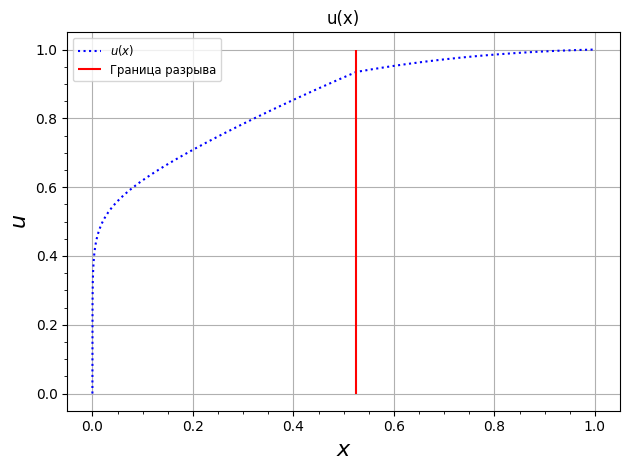

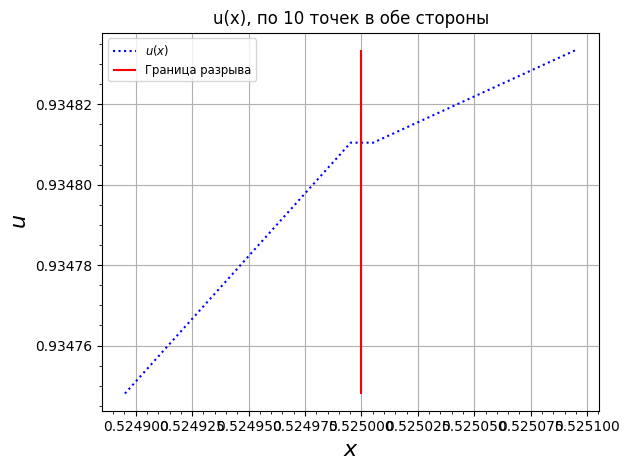

In [76]:
L = 100000

x_begin = 0
x_end   = 1

u_0 = 0
u_L = 1

x = np.linspace(x_begin, x_end, L)
u = np.zeros(L)
u[0] = u_0
u[-1] = u_L

h = (x_end - x_begin) / (L - 1)

x, u = tridiagonal_matrix_algorithm(x, u, h, L)

plot_graph(x, u, "u(x)")

x0_index = int(np.floor(x_0 / h))
plot_graph(x[x0_index - 10 : (x0_index + 1) + 10], u[x0_index - 10 : (x0_index + 1) + 10], "u(x), по 10 точек в обе стороны")